In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import FDTDIResponseGenerator
from Triangle_BBH.Utils import Likelihood, Fstatistics
from Triangle_BBH.Fisher import *

import multiprocessing
if __name__=='__main__':
    multiprocessing.set_start_method("fork")

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy 
no cupy
No CuPy or GPU PhenomHM module.
has BBHx waveform


## Data settings 

In [2]:
t_start = 200. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 15. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(14401,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_CPU = xp.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((14137,), (14137,))

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_CPU = Orbit(OrbitDir="/Users/taijidatacenter/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") 

# initialize  waveform generator 
WFG_CPU = WaveformGenerator(
    mode="primary", 
)

# initialize response generator 
FDTDI_CPU = FDTDIResponseGenerator(
    orbit_class=orbit_CPU, 
    waveform_generator=WFG_CPU, 
)

# response settings 
response_kwargs_CPU = dict(
    modes=[(2, 2)], 
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    tc_at_constellation=True, # whether tc is the coalescence time at constellation center (True) or SSB (False)
    TDIGeneration='2nd',
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
)

## Source parameter priors 

In [5]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [(t_start + 0.5 * Tobs) / DAY, (t_end - 0.1 * Tobs) / DAY] # ensure the inclusion of long enough GW waveform 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 2.02500000e+02,  2.04500000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

In [6]:
intrinsic_param_priors[4]

array([202.5, 204.5])

## Noise model 

In [7]:
arm_time = np.mean(intrinsic_param_priors[4]) * DAY 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_CPU.LTTfunctions()[key](arm_time)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

((3, 14137), (14137, 3, 3))

## Data simulation 

In [8]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 650285.1873053649
mass_ratio : 0.9809835926895634
spin_1z : -0.872223827711979
spin_2z : -0.033138579339713425
coalescence_time : 203.72540562798395
coalescence_phase : 0.49814465090794297
luminosity_distance : 30801.870367004736
inclination : 1.8649168862280283
longitude : 5.273157911767585
latitude : 0.02289882365745279
psi : 0.5113975625515467
optimal SNR: 1384.1377051111426


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

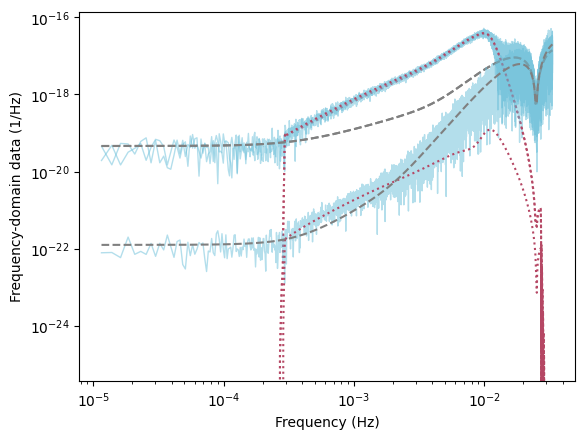

In [9]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel]), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel]), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [10]:
Fstat = Fstatistics(
    response_generator=FDTDI_CPU, 
    frequency=data_frequencies_CPU, 
    data=data_channels, 
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_CPU, 
    use_gpu=False
)

number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


### test waveform and parameter recovery

In [11]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 650285.1873053649,
 'mass_ratio': 0.9809835926895634,
 'spin_1z': -0.872223827711979,
 'spin_2z': -0.033138579339713425,
 'coalescence_time': 203.72540562798395,
 'longitude': 5.273157911767585,
 'latitude': 0.02289882365745279}

In [12]:
rec_a = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_a=True, 
)
# print(rec_a.shape)

rec_ext_params = Fstat.a_to_extrinsic(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | true value | difference")
for k, v in rec_ext_params.items():
    print(k, ":", mbhb_parameters[k], v-mbhb_parameters[k])

parameter name | true value | difference
luminosity_distance : 30801.870367004736 -45.173646740222466
inclination : 1.8649168862280283 -0.0006554124533537653
psi : 0.5113975625515467 9.923389937505078e-05
coalescence_phase : 0.49814465090794297 -0.00026167157971973554


In [13]:
rec_wave1 = FDTDI_CPU.Response(
    rec_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

rec_wave2 = Fstat.calculate_Fstat(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)

rec_wave1.shape, rec_wave2.shape 

((3, 14137), (3, 14137))

(1e-25, 6.059396867920772e-16)

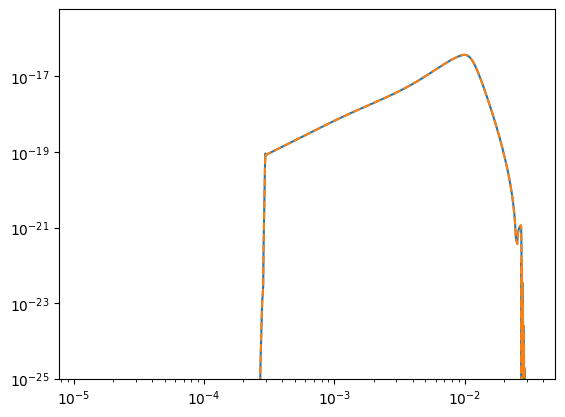

In [14]:
plt.loglog(data_frequencies_CPU, np.abs(rec_wave1[0]))
plt.loglog(data_frequencies_CPU, np.abs(rec_wave2[0]), linestyle="--")
plt.loglog(data_frequencies_CPU, np.abs(rec_wave1[0] - rec_wave2[0]))
plt.ylim(1e-25,)

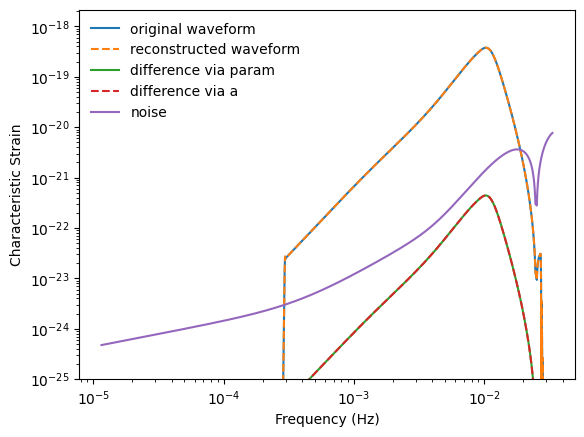

In [15]:
plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0]) * data_frequencies, linestyle="--", label="reconstructed waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0] - wf_channels[0]) * data_frequencies, label="difference via param")
plt.loglog(data_frequencies, np.abs(rec_wave2[0] - wf_channels[0]) * data_frequencies, label="difference via a", linestyle="--")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

### optimization from prior 

In [16]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams), normalized to (0, 1)
    """
    int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
    return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-7,
    atol=1e-9,
    # tol=1e-6,
    # atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=True,
    # vectorized=True,
    workers=-1, 
)

/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))


In [17]:
print(DE_result)

             message: Optimization terminated successfully.
             success: True
                 fun: -959342.9425890397
                   x: [ 3.131e-01  9.763e-01  4.549e-02  4.516e-01
                        6.127e-01  1.833e-01  8.997e-01]
                 nit: 263
                nfev: 129400
          population: [[ 3.131e-01  9.763e-01 ...  1.833e-01  8.997e-01]
                       [ 3.131e-01  9.688e-01 ...  1.836e-01  8.964e-01]
                       ...
                       [ 3.131e-01  9.799e-01 ...  1.846e-01  9.006e-01]
                       [ 3.131e-01  9.807e-01 ...  1.832e-01  9.005e-01]]
 population_energies: [-9.593e+05 -9.593e+05 ... -9.593e+05 -9.593e+05]
                 jac: [-2.188e+03  1.080e+01  1.165e+02  9.746e+01
                       -1.654e+03 -3.185e+01 -2.736e+01]


### reconstruct parameters and waveforms 

In [18]:
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

searched_a = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic(searched_a)

searched_params = dict(searched_int_params, **searched_ext_params)

print("parameter name | true value | difference")
for k, v in searched_params.items():
    print(k, mbhb_parameters[k], np.abs(v-mbhb_parameters[k]))

parameter name | true value | difference
chirp_mass 650285.1873053649 42.81519080570433
mass_ratio 0.9809835926895634 0.00229405831163354
spin_1z -0.872223827711979 0.054112456887835725
spin_2z -0.033138579339713425 0.05398148433840688
coalescence_time 203.72540562798395 4.771298733885487e-07
longitude 5.273157911767585 4.12121205398071
latitude 0.02289882365745279 0.9034403478901969
luminosity_distance 30801.870367004736 693.8923349453908
inclination 1.8649168862280283 0.5850004413169161
psi 0.5113975625515467 0.03217394343852742
coalescence_phase 0.49814465090794297 0.002644824588972583


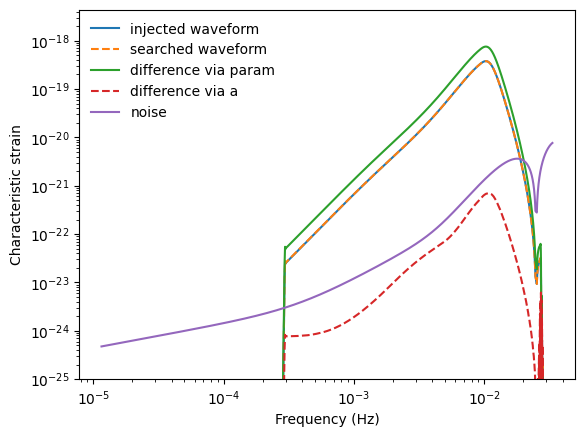

In [19]:
searched_wf1 = FDTDI_CPU.Response(
    searched_params, 
    data_frequencies_CPU, 
    **response_kwargs_CPU
)

searched_wf2 = Fstat.calculate_Fstat(
    intrinsic_parameters=searched_int_params, 
    return_recovered_wave=True
)

plt.loglog(data_frequencies, np.abs(wf_channels[0]) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0]) * data_frequencies, linestyle="--", label="searched waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0] - wf_channels[0]) * data_frequencies, linestyle="-", label="difference via param")
plt.loglog(data_frequencies, np.abs(searched_wf2[0] - wf_channels[0]) * data_frequencies, linestyle="--", label="difference via a")
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strain")
plt.legend(loc="upper left", frameon=False)

## Fisher analysis 

In [20]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_CPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_CPU, 
    )
    return res

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.01,
    'luminosity_distance': 10.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    # param_dict=mbhb_parameters, 
    param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 98.19146061846754,
 'mass_ratio': 0.013447311413485943,
 'spin_1z': 0.1406165788466719,
 'spin_2z': 0.1418772737135144,
 'coalescence_time': 1.4828490285618895e-06,
 'coalescence_phase': 0.003448508472798301,
 'luminosity_distance': 422.8907492625646,
 'inclination': 0.002040029308004073,
 'longitude': 0.047135447603127954,
 'latitude': 0.03425777361822875,
 'psi': 0.03290493963434922}

In [21]:
print("parameter name | difference | FIM bound | ratio")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), FIM.param_errors[k], np.abs(v-mbhb_parameters[k]) / FIM.param_errors[k])

parameter name | difference | FIM bound | ratio
chirp_mass 42.81519080570433 98.19146061846754 0.4360378238191905
mass_ratio 0.00229405831163354 0.013447311413485943 0.17059605753852708
spin_1z 0.054112456887835725 0.1406165788466719 0.38482273805594336
spin_2z 0.05398148433840688 0.1418772737135144 0.38048013558118515
coalescence_time 4.771298733885487e-07 1.4828490285618895e-06 0.3217656445115544
longitude 4.12121205398071 0.047135447603127954 87.43339171573334
latitude 0.9034403478901969 0.03425777361822875 26.371834841289022
luminosity_distance 693.8923349453908 422.8907492625646 1.6408311984960602
inclination 0.5850004413169161 0.002040029308004073 286.76080241674066
psi 0.03217394343852742 0.03290493963434922 0.9777846060820996
coalescence_phase 0.002644824588972583 0.003448508472798301 0.7669473947461215


## Test across population 

In [ ]:
truths_list = [] 
searched_list = [] 
FIM_bound_list = [] 
snr_list = [] 
res_snr_list = [] 

for test_idx in tqdm(range(100)):

    # generate source parameter and clean signal 
    mbhb_parameters = {
        'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
        'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
        'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
        'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
        'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
        'coalescence_phase': np.random.uniform(0, TWOPI),
        'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
        'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
        'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
        'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
        'psi': np.random.uniform(0, PI) # [rad]
        }
    wf_channels = FDTDI_CPU.Response(mbhb_parameters, data_frequencies_CPU, **response_kwargs_CPU)

    # generate frequency-domain noises 
    Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

    # combine signal and noise 
    data_channels = wf_channels + noise_channels 

    opt_SNR = FrequencyDomainCovarianceSNR(wf_channels, InvCovMat)
    snr_list.append(opt_SNR)

    Fstat = Fstatistics(
        response_generator=FDTDI_CPU, 
        frequency=data_frequencies_CPU, 
        data=data_channels, 
        invserse_covariance_matrix=InvCovMat, 
        response_parameters=response_kwargs_CPU, 
        use_gpu=False
    )

    def cost_function(norm_int_params):
        """   
            norm_int_params: shape (Nparams), normalized to (0, 1)
        """
        int_params = norm_int_params * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nparams)
        params_in = Fstat.IntParamArr2ParamDict(int_params) # (Nparams) -> dictionary
        return -Fstat.calculate_Fstat(intrinsic_parameters=params_in) # float

    n_dim_int = 7 
    lower_bounds = np.zeros(n_dim_int) 
    upper_bounds = np.ones(n_dim_int) 
    bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

    DE_result = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-8,
        atol=1e-10,
        # tol=1e-7,
        # atol=1e-9,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=True,
        # vectorized=True,
        workers=-1, 
    )

    searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

    searched_a = Fstat.calculate_Fstat(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic(searched_a)

    searched_params = dict(searched_int_params, **searched_ext_params)
    
    searched_wf = Fstat.calculate_Fstat(
        intrinsic_parameters=searched_int_params, 
        return_recovered_wave=True, 
    ) 
    res_snr_list.append(FrequencyDomainCovarianceSNR(searched_wf-wf_channels, InvCovMat))

    
    def fisher_waveform_wrapper(param_dict, frequencies):
        res = FDTDI_CPU.Response(
            parameters=param_dict, 
            freqs=xp.array(frequencies),  
            **response_kwargs_CPU, 
        )
        return res

    # set initial steps 
    analyze_param_step_dict = {
        'chirp_mass': 10.,
        'mass_ratio': 0.01,
        'spin_1z': 0.01,
        'spin_2z': 0.01,
        'coalescence_time': 0.001,
        'coalescence_phase': 0.01,
        'luminosity_distance': 10.,
        'inclination': 0.01,
        'longitude': 0.01,
        'latitude': 0.01,
        'psi': 0.01
        }
    for k, v in analyze_param_step_dict.items():
        analyze_param_step_dict[k] = -v 

    FIM = MultiChannelFisher(
        waveform_generator=fisher_waveform_wrapper, 
        param_dict=mbhb_parameters, 
        # param_dict=searched_params, 
        analyze_param_step_dict=analyze_param_step_dict, 
        frequency=data_frequencies, 
        inverse_covariance=InvCovMat, 
        verbose=0,
    )

    FIM.auto_test_step()
    FIM.calculate_Fisher()
    FIM.calculate_errors() 

    truths_list.append(mbhb_parameters)
    searched_list.append(searched_params)
    FIM_bound_list.append(FIM.param_errors)
    
    print("optimal SNR =", snr_list[test_idx])
    print("residual SNR =", res_snr_list[test_idx])
    print("tc deviation =", truths_list[test_idx]["coalescence_time"] - searched_list[test_idx]["coalescence_time"])

  0%|          | 0/100 [00:00<?, ?it/s]

number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


  1%|          | 1/100 [56:46<93:41:03, 3406.71s/it]

optimal SNR = 1873.0015138141127
residual SNR = 5.4566223644252645
tc deviation = 1.864006668483853e-05
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/

optimal SNR = 388.1569884293027
residual SNR = 2.372957062567873
tc deviation = 2.0315081883381936e-07
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
  3%|▎         | 3/100 [1:08:11<27:15:34, 1011.70s/it]

optimal SNR = 1454.6211735378185
residual SNR = 2.272110100576494
tc deviation = -1.7054374268354877e-06
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


  4%|▍         | 4/100 [1:13:42<19:48:28, 742.80s/it] 

optimal SNR = 2769.588061130282
residual SNR = 6.413640125988724
tc deviation = -7.637850200126195e-05
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/

optimal SNR = 210.59869048755982
residual SNR = 3.3165240781475185
tc deviation = 3.4600717043531404e-05
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
  6%|▌         | 6/100 [1:25:40<13:35:34, 520.58s/it]

optimal SNR = 3104.795153753991
residual SNR = 7.407065730815223
tc deviation = 2.989477962955789e-06
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


  7%|▋         | 7/100 [2:09:19<31:09:59, 1206.44s/it]

optimal SNR = 3085.7710669551325
residual SNR = 3.5638679001796616
tc deviation = 1.2487767833135877e-06
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


  8%|▊         | 8/100 [2:13:38<23:07:33, 904.93s/it] 

optimal SNR = 2707.305178853961
residual SNR = 5.458286972242457
tc deviation = -5.50729791939375e-05
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


  9%|▉         | 9/100 [2:18:47<18:09:40, 718.46s/it]

optimal SNR = 707.525324595756
residual SNR = 3.083533396290761
tc deviation = -6.200160953540035e-07
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


 10%|█         | 10/100 [2:26:04<15:47:21, 631.57s/it]

optimal SNR = 95.74868664027933
residual SNR = 3.369902150564359
tc deviation = 4.738224544098557e-05
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
 11%|█         | 11/100 [2:43:09<18:35:36, 752.10s/it]

optimal SNR = 1854.277890671149
residual SNR = 2.878267118082957
tc deviation = -4.3090145140922687e-07
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/

optimal SNR = 2116.894718322254
residual SNR = 8.088345138383426
tc deviation = 7.481843931600451e-05
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/

optimal SNR = 2484.3373701239243
residual SNR = 3.8249224456131
tc deviation = 0.00016763021397991906
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:199: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), np.fabs(fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2))
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/site-packages/WF4Py/waveform_models/IMRPhenomHM.py:305: RuntimeWarning: invalid value encountered in sqrt
  fpeak = np.where(gamma2 >= 1.0, np.fabs(fring - (fdamp*gamma3)/gamma2), fring + (fdamp*(-1.0 + np.sqrt(1.0 - gamma2*gamma2))*gamma3)/gamma2)
/Users/taijidatacenter/miniconda3/envs/tri_env/lib/python3.9/

optimal SNR = 18405.479691172797
residual SNR = 10.66815239012202
tc deviation = -9.302955530188228e-05
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


 15%|█▌        | 15/100 [4:38:30<50:07:17, 2122.79s/it]

optimal SNR = 1244.5790469380202
residual SNR = 3.567174634257349
tc deviation = -1.4407175399355765e-06
number of freuqncies: 14137
min and max frequencies: 1.1574074074074073e-05 0.03333333333333333
response kwargs: {'modes': [(2, 2)], 'tmin': 200.0, 'tmax': 205.0, 'tc_at_constellation': True, 'TDIGeneration': '2nd', 'optimal_combination': True, 'output_by_mode': False}


Process ForkPoolWorker-203:
 15%|█▌        | 15/100 [4:38:36<26:18:49, 1114.47s/it]


KeyboardInterrupt: 

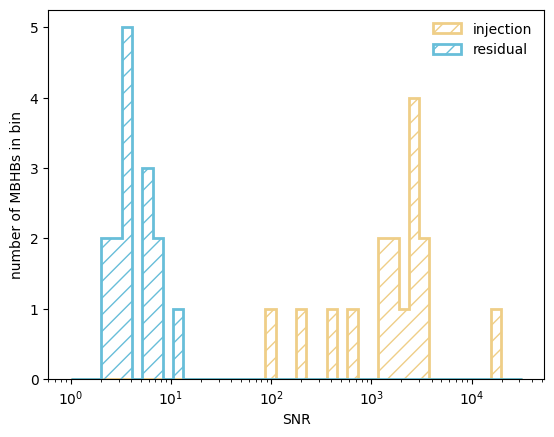

In [45]:
bins = np.logspace(0, 4.5, 45)
plt.hist(snr_list, bins=bins, density=False, facecolor=None, edgecolor=YELLOW, hatch="//", histtype='step', lw=2, label="injection"); 
plt.hist(res_snr_list, bins=bins, density=False, facecolor=None, edgecolor=BLUE, hatch="//", histtype='step', lw=2, label="residual"); 
plt.xlabel("SNR")
plt.ylabel("number of MBHBs in bin")
plt.xscale("log")
plt.legend(loc="upper right", frameon=False)

In [46]:
Mc_list = np.array([paramdict["chirp_mass"] for paramdict in truths_list])
q_list = np.array([paramdict["mass_ratio"] for paramdict in truths_list])
s1_list = np.array([paramdict["spin_1z"] for paramdict in truths_list])
s2_list = np.array([paramdict["spin_2z"] for paramdict in truths_list])
tc_list = np.array([paramdict["coalescence_time"] for paramdict in truths_list])
dl_list = np.array([paramdict["luminosity_distance"] for paramdict in truths_list])
inc_list = np.array([paramdict["inclination"] for paramdict in truths_list])
lon_list = np.array([paramdict["longitude"] for paramdict in truths_list])
lat_list = np.array([paramdict["latitude"] for paramdict in truths_list])

Mc_list1 = np.array([paramdict["chirp_mass"] for paramdict in searched_list])
q_list1 = np.array([paramdict["mass_ratio"] for paramdict in searched_list])
s1_list1 = np.array([paramdict["spin_1z"] for paramdict in searched_list])
s2_list1 = np.array([paramdict["spin_2z"] for paramdict in searched_list])
tc_list1 = np.array([paramdict["coalescence_time"] for paramdict in searched_list])
dl_list1 = np.array([paramdict["luminosity_distance"] for paramdict in searched_list])
inc_list1 = np.array([paramdict["inclination"] for paramdict in searched_list])
lon_list1 = np.array([paramdict["longitude"] for paramdict in searched_list])
lat_list1 = np.array([paramdict["latitude"] for paramdict in searched_list])

Mc_list2 = np.array([paramdict["chirp_mass"] for paramdict in FIM_bound_list])
q_list2 = np.array([paramdict["mass_ratio"] for paramdict in FIM_bound_list])
s1_list2 = np.array([paramdict["spin_1z"] for paramdict in FIM_bound_list])
s2_list2 = np.array([paramdict["spin_2z"] for paramdict in FIM_bound_list])
tc_list2 = np.array([paramdict["coalescence_time"] for paramdict in FIM_bound_list])
dl_list2 = np.array([paramdict["luminosity_distance"] for paramdict in FIM_bound_list])
inc_list2 = np.array([paramdict["inclination"] for paramdict in FIM_bound_list])
lon_list2 = np.array([paramdict["longitude"] for paramdict in FIM_bound_list])
lat_list2 = np.array([paramdict["latitude"] for paramdict in FIM_bound_list])

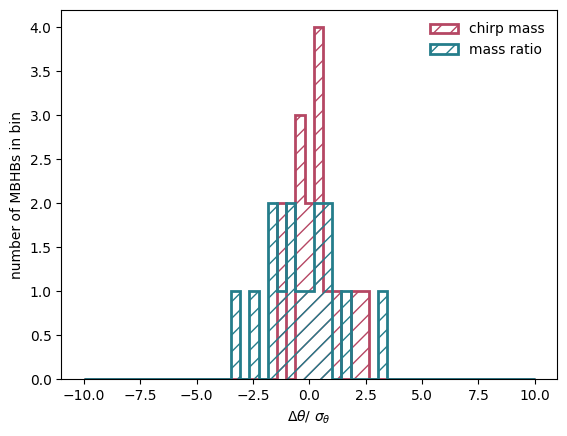

In [47]:
bins = np.linspace(-10, 10, 50)
plt.hist((Mc_list1 - Mc_list) / Mc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="chirp mass");
plt.hist((q_list1 - q_list) / q_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="mass ratio");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

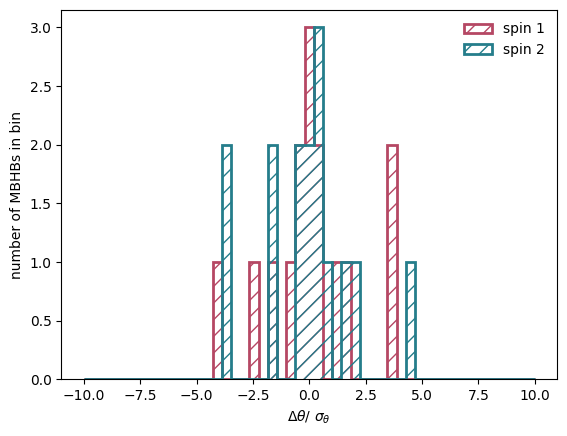

In [48]:
bins = np.linspace(-10, 10, 50)
plt.hist((s1_list1 - s1_list) / s1_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="spin 1");
plt.hist((s2_list1 - s2_list) / s2_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="spin 2");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

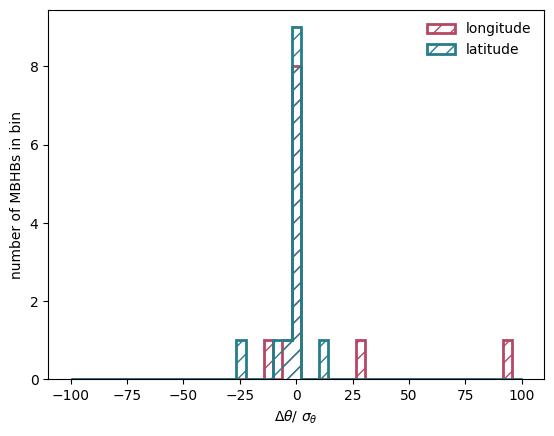

In [53]:
bins = np.linspace(-100, 100, 50)
plt.hist((lon_list1 - lon_list) / lon_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="longitude");
plt.hist((lat_list1 - lat_list) / lat_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="latitude");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

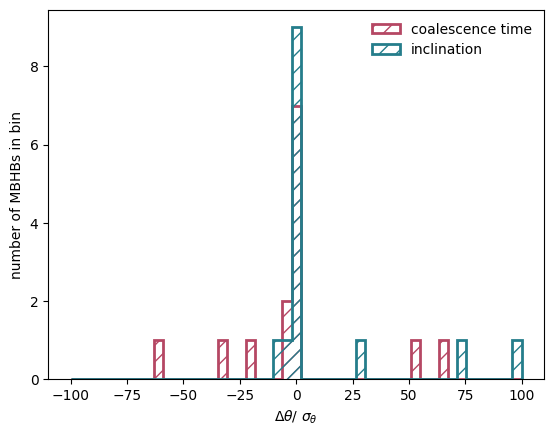

In [54]:
bins = np.linspace(-100, 100, 50)
plt.hist((tc_list1 - tc_list) / tc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="coalescence time");
plt.hist((inc_list1 - inc_list) / inc_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="inclination");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

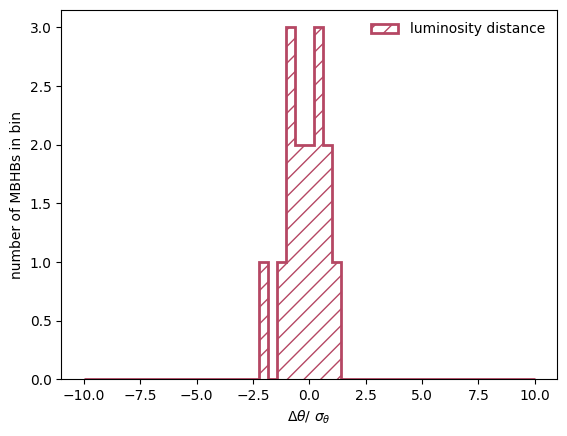

In [55]:
bins = np.linspace(-10, 10, 50)
plt.hist((dl_list1 - dl_list) / dl_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="luminosity distance");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

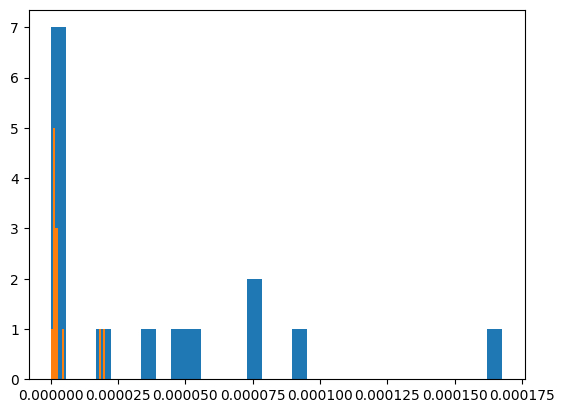

In [60]:
plt.hist(np.abs(tc_list1 - tc_list), bins=30);
plt.hist(tc_list2, bins=30);